In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0   0.726859  0.881542 -1.835403 -0.010938 -0.041637  0.963237  0.193409   
  1  -0.296616 -0.137438 -1.701694 -0.288447  0.090363 -0.238930 -0.492204   
  2  -0.039624 -0.160336 -0.664074 -0.322729  0.128028 -0.346601 -0.550633   
  3  -0.255701 -0.318699 -1.442756 -0.286292  1.040827  0.218362 -0.116987   
  4   0.782003  0.141115 -0.575729  0.489924  0.296048  1.738391 -0.364764   
  5   0.279850 -1.223828 -0.930808 -0.630745 -0.327501 -0.578055  0.050662   
  6   0.401696 -0.223402 -1.025243 -0.738329 -0.463913  0.576677 -1.347696   
  7  -0.620655  0.639579  0.343139  0.201477 -0.512435 -1.219000 -0.189448   
  8  -0.345944  0.231429 -1.432606 -0.947599 -0.143854  0.358916  0.337329   
  9  -0.560255 -0.288852  0.085673 -0.419468  0.084958 -0.073698 -1.408349   
  10  0.325708 -0.437698 -0.245503 -0.171068 -0.005848 -0.875799  0.054442   
  11 -0.651729 -0.983447 -0.734434 -0.835122  0.451458  0.251643 -0.701010   
  12  0.301411 -0.379083 -1.423788 -0.783558 -0.308503  0.225127  0.792580   
  13 -0.087287  0.252747 -0.761989  0.684933 -0.705802  0.219889  0.063869   
  14 -0.500338  0.654047  0.394157 -0.693948 -1.301368 -1.267488 -0.043355   
  15  0.359079 -0.289648  0.395438  0.351832 -0.251668  0.527353 -0.123564   
  16 -0.313486 -0.454022 -0.792157  0.199353 -0.660294 -1.188683 -0.397693   
  17 -0.445791 -1.002401 -1.543345 -0.984765 -1.071363  0.042701 -0.597668   
  18  0.452308 -0.319656 -0.372286 -0.700541  0.290000  0.569275  1.472708   
  19  0.131820 -0.533108 -0.636227 -1.861764 -0.727128 -0.195611 -0.113026   
  20  0.166728  0.185996 -0.826399 -0.478263  0.431199 -0.110565 -0.515625   
  21  0.193139 -0.491847 -0.272550 -1.387444 -0.527548  0.404341 -0.505044   
  22  0.498440  0.257027 -0.679143 -1.288277  0.090388 -0.861365 -0.045992   
  23 -0.482930 -0.841533  0.031408 -0.131247 -0.093959  0.416534 -0.781997   
  24 -0.536024  0.037453 -0.811252 -1.153081 -0.009989  0.233715  0.093612   
1 0  -0.356667 -0.558646 -1.313267 -0.219416  0.126480  0.079226 -0.368591   
  1  -0.880088  0.147157 -1.087949 -0.199452  0.243542  0.247830  0.059444   
  2  -0.631542  0.461240  1.044098  1.442730 -0.290953  0.326179 -0.080988   
  3  -0.492555 -0.072269 -0.203293  0.606435  0.173297  0.409587  0.775605   
  4  -0.617284 -0.807438 -0.640050 -0.220905  0.260633 -0.551150  0.518823   

            X8        X9       X10  ...       X94       X95       X96  \
0 0   0.090522 -0.405187  1.290687  ...  1.290767  0.978472 -0.458043   
  1   1.298364  0.489268  1.150725  ...  0.113776  0.612870  0.201666   
  2  -0.358769 -0.373757 -0.221158  ...  0.640892  1.058567 -0.262993   
  3   0.475842  0.637427 -0.115931  ...  0.769669  0.307769  1.042184   
  4  -0.758236  0.223529 -0.276647  ...  0.025523 -0.058751 -0.066672   
  5  -0.106877  0.009157 -0.356256  ...  0.308124  0.130185 -0.177252   
  6   0.265597  0.143731  0.536213  ...  0.575733 -0.073284  0.674144   
  7  -0.272078 -0.460412 -0.147218  ...  0.576421  0.159456  0.537737   
  8   0.030390 -0.196944 -0.352355  ... -0.578370 -0.188518  0.155861   
  9  -0.416912  1.091257  0.788699  ...  1.351408  0.621544 -0.025137   
  10  0.214654 -0.731322 -0.469564  ...  0.049177  0.500145  0.634838   
  11  0.150276 -0.138541 -0.527805  ...  1.424337 -0.249287  0.584797   
  12  0.433418 -0.483298  1.095139  ...  0.983754 -0.152308 -0.642903   
  13  0.035117  0.174516  0.926675  ...  0.325583  0.446155  0.006768   
  14 -1.049356 -0.075392  0.182049  ...  0.700240  0.093910  0.222500   
  15  0.401339 -0.211702  0.116961  ...  0.759024 -0.290341 -0.270524   
  16 -0.689785  0.011272  0.801687  ...  0.297297  0.872741 -0.034648   
  17  0.089379 -0.312307  0.626619  ...  0.351411 -0.039479  0.806205   
  18  0.468489 -0.583512  1.148032  ...  0.180309  0.535071  0.100716   
  19 -0.426241  0.733779 -0.481114  ...  0.711166  0.342797 -0.298369   
  20  0.097250 -0.183505  0.212797  ... -0.458345 -1.229989 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t         P>|t|     2.5 %    97.5 %
D  0.975886  0.047583  20.509011  1.788935e-93  0.882624  1.069147


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



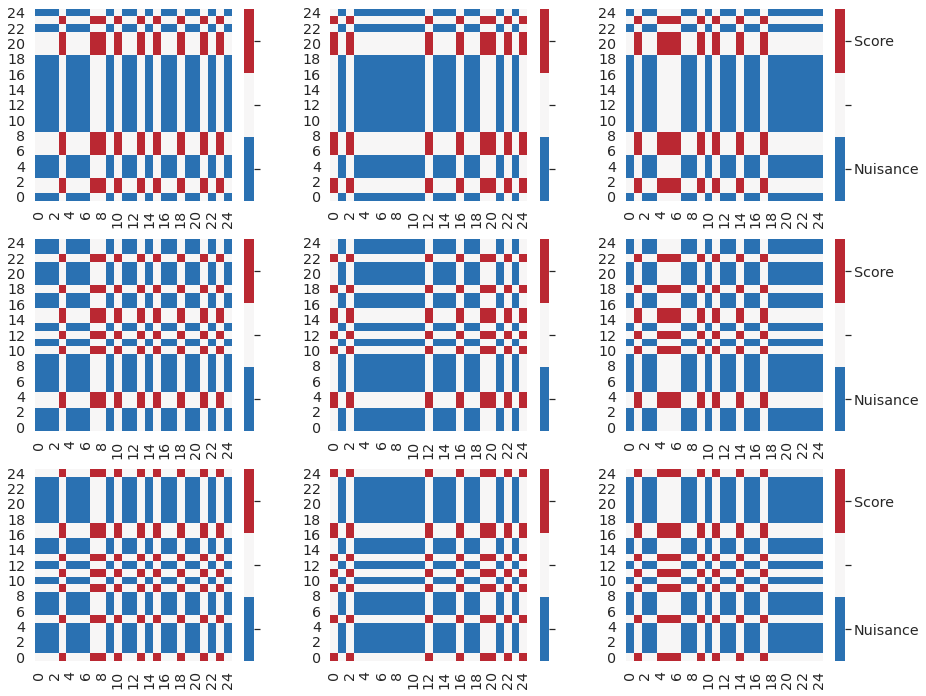

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



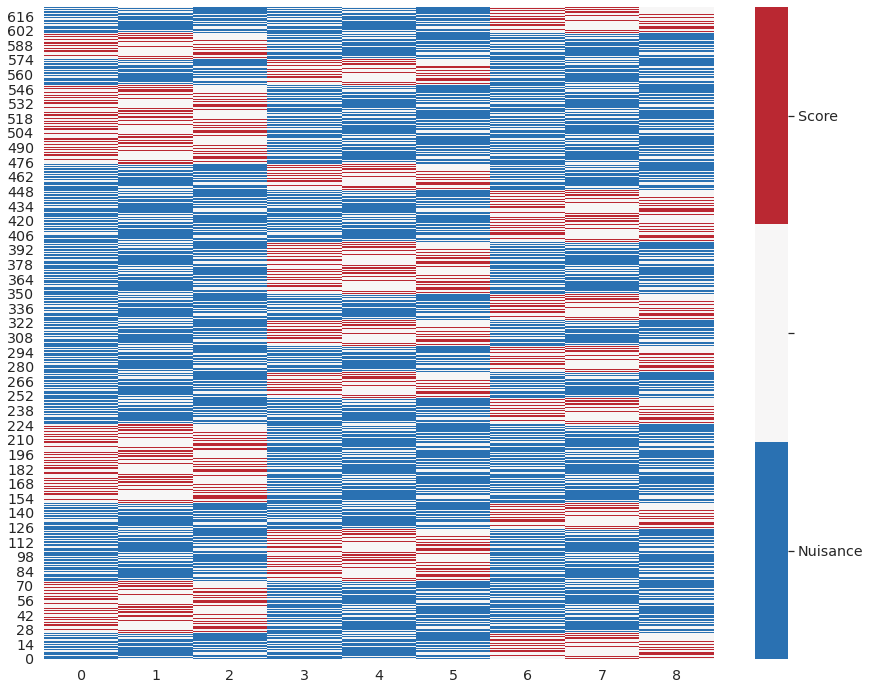

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])